## **Project Title: Anomaly Detection in Credit Card Transactions**

### **Project Goal:**

Use unsupervised learning techniques to identify potential fraudulent credit card transactions without labeled data.

### **Dataset:**

Credit Card Fraud Detection – Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardataraud
also found in data folder

- 284,807 transactions

- Features are anonymized PCA components (V1 to V28) + Amount, Time

## **Part 1: EDA**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [62]:
data = pd.read_csv('./data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [63]:
data.shape

(284807, 31)

In [64]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<Axes: >

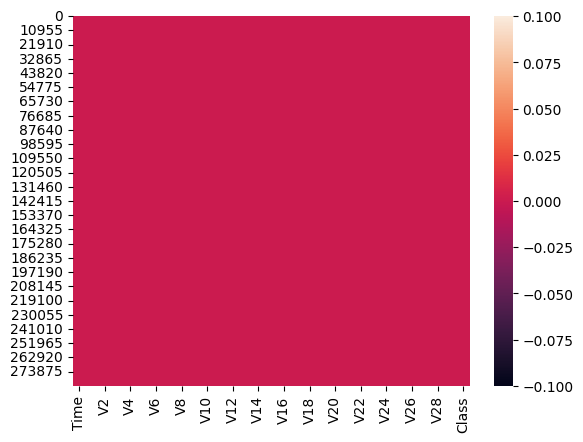

In [66]:
sns.heatmap(data.isnull())

Checking how many fraud cases exist compared to all transactions and calculates the fraud percentage.
This helps us understand how imbalanced the dataset is and how many anomalies the model should expect.

In [67]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [68]:
fraud_count = data['Class'].sum()
total = len(data)
fraud_ratio = fraud_count / total
print(f"Total transactions: {total}, Fraudulent: {fraud_count}, Fraud ratio: {fraud_ratio:.6f}")


Total transactions: 284807, Fraudulent: 492, Fraud ratio: 0.001727


In [69]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


from the describe function we can see that cols V1....V28 are standardized since Mean ≈ 0 and Std ≈ 1 so we must scale the other cols: Time and Amount in the next steps

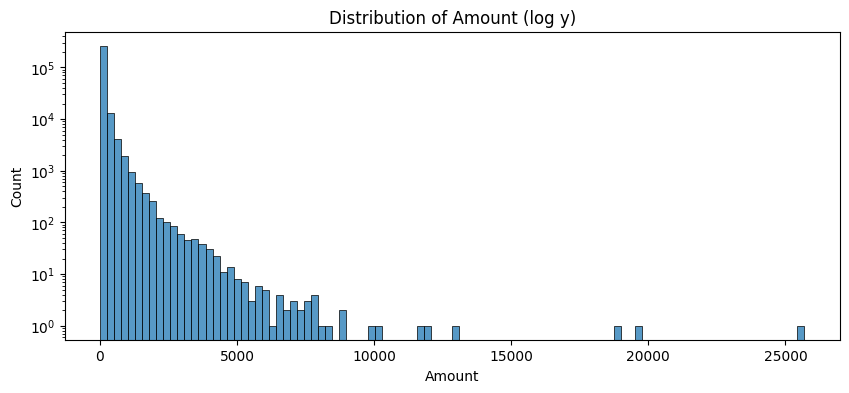

In [70]:
# Plot Amount distribution (log scale for better view)
plt.figure(figsize=(10,4))
sns.histplot(data['Amount'], bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of Amount (log y)')
plt.show()


From the histogram we conclude that: 
 - Most transactions involve very small amounts, the majority are under $100.
 - As the transaction amount increases, the number of transactions drops sharply, showing a right-skewed distribution.
 - Very large transactions (above $5,000, $10,000+, $20,000+) are extremely rare, appearing as isolated bars.

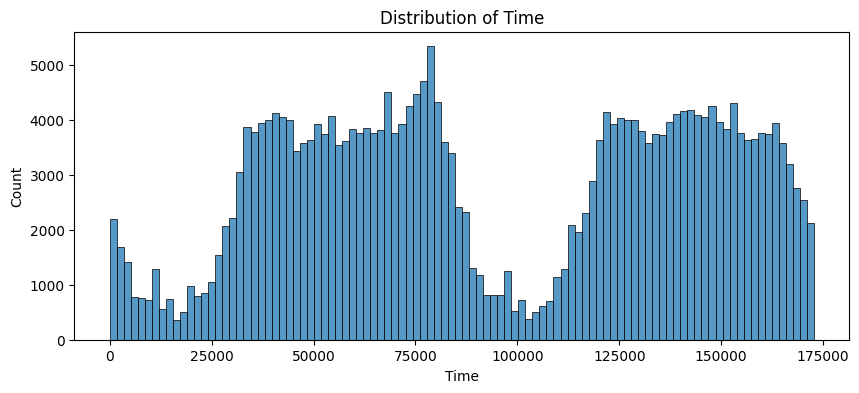

In [71]:
# Time distribution
plt.figure(figsize=(10,4))
sns.histplot(data['Time'], bins=100)
plt.title('Distribution of Time')
plt.show()

From the graph we can conclude that:
 - The plot shows two clear peaks of high activity.
 This means transactions happen in waves, likely representing busy daytime periods vs. quieter nighttime hours.
 - There are low-activity gaps between the peaks, suggesting times of day when customers rarely make transactions.
 - Since “Time” represents the number of seconds from the first transaction, these patterns reflect daily cycles in user behavior.

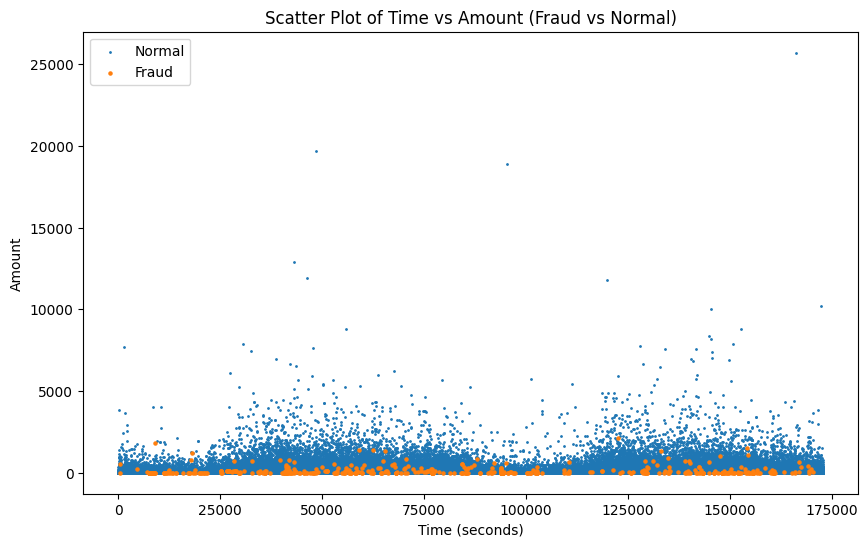

In [72]:

# Prepare data
fraud = data[data['Class'] == 1]
normal = data[data['Class'] == 0]

# Create scatter plot
plt.figure(figsize=(10,6))

plt.scatter(normal['Time'], normal['Amount'], s=1, label='Normal')
plt.scatter(fraud['Time'], fraud['Amount'], s=5, label='Fraud')

plt.xlabel('Time (seconds)')
plt.ylabel('Amount')
plt.legend()
plt.title('Scatter Plot of Time vs Amount (Fraud vs Normal)')

plt.show()

The scatter plot shows that fraud transactions occur across the entire time range and mostly involve small amounts. High-value transactions are almost always legitimate. There’s significant overlap between fraud and non-fraud points, so Time and Amount alone are not enough to detect fraud, and we must rely on deeper PCA components (V1–V28) and anomaly detection models.

## **Part 2: Data Preprocessing**

since we saw that the values of Time and Amount are not normalized we have to normalize them:

In [73]:
from sklearn.preprocessing import  MinMaxScaler

scaler = MinMaxScaler()
data[['Time','Amount']] = scaler.fit_transform(data[['Time','Amount']])

In [74]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,0.55,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
std,0.27,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,0.01,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,0.31,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,0.00,0.00
50%,0.49,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,0.00,0.00
75%,0.81,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,0.00,0.00
max,1.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,1.00,1.00


In [75]:
from sklearn.decomposition import PCA
x_scaled = data.drop('Class', axis=1)
pca = PCA()
pca_data = pd.DataFrame(pca.fit_transform(x_scaled ))
pca.explained_variance_

array([3.83756363e+00, 2.72685580e+00, 2.31284864e+00, 2.00553299e+00,
       1.90735134e+00, 1.77524922e+00, 1.53097132e+00, 1.42658609e+00,
       1.20699875e+00, 1.18567133e+00, 1.04690344e+00, 9.99559819e-01,
       9.90848898e-01, 9.19657110e-01, 8.40383191e-01, 7.67829942e-01,
       7.21800980e-01, 7.03160252e-01, 6.62726893e-01, 5.94544071e-01,
       5.39708097e-01, 5.28272831e-01, 3.90170279e-01, 3.66830455e-01,
       2.76357739e-01, 2.32677137e-01, 1.62921693e-01, 1.08964748e-01,
       3.85189343e-02, 7.82201863e-06])

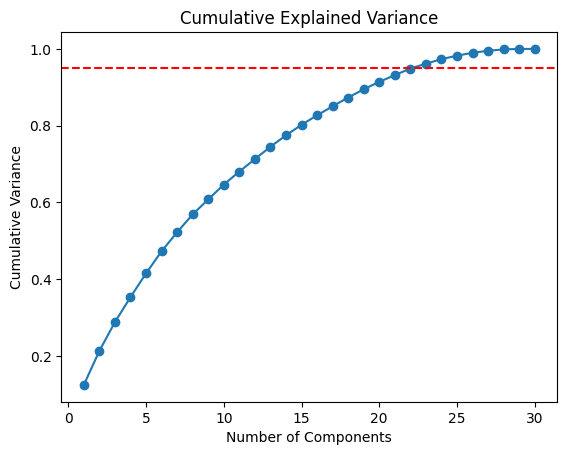

In [76]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()               
pca.fit(x_scaled )

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.95, color='red', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Explained Variance")
plt.show()


from the graph above we can see that:
- Red dashed line = 95% variance threshold
- Curve crosses 95% around component 23

so we need to set n_components = 23 to capture 95% of the information.

In [77]:
pca = PCA(n_components=23)
X_pca = pca.fit_transform(x_scaled )
X_pca.shape

(284807, 23)

## **Part 3: Unsupervised ML Techniques**


## **1st Technique:**

## Isolation Forest (iForest) Main Ideas
**Goal:** Anomaly detection (unsupervised outlier detection).

**Core Principle:** Anomalies (outliers) are few and structurally different from the normal data points, meaning they are easier to isolate than normal points.

**1. How It Works**
- Isolation Trees (iTrees): The algorithm builds an ensemble of simple binary trees (the "forest"). Unlike standard decision trees, iTrees are built to isolate points, not to classify them.

- Random Partitioning: Each split in an iTree is made by randomly selecting a feature and then randomly selecting a split value within the range of that feature. This recursive splitting aims to quickly partition the space.

**2. Anomaly Scoring**
- Path Length: The key concept is the path length—the number of edges a data point traverses from the root of the tree until it is isolated at a leaf node.

- Anomalies: Anomalies are isolated closer to the root, resulting in a shorter average path length.

- Normal Points: Normal data points are grouped together and require more random partitions to be separated, resulting in a longer average path length.

- Anomaly Score: The final anomaly score for a point is derived from its average path length across all iTrees in the forest. Shorter average path length = higher anomaly score (more likely to be an outlier).

In [78]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Use PCA-transformed data (23 components = 95% variance)
X = X_pca

# True labels (only for evaluation, not for training)
y_true = data['Class']

# Fraud ratio (used as contamination factor)
fraud_ratio = y_true.mean()
print("Fraud ratio (contamination):", fraud_ratio)

Fraud ratio (contamination): 0.001727485630620034


In [ ]:
iso = IsolationForest(
    n_estimators=100,
    contamination=fraud_ratio,   
    random_state=42,
    verbose=1
)

iso.fit(X)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


,n_estimators,100
,max_samples,'auto'
,contamination,np.float64(0....7485630620034)
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,1
,warm_start,False


In [80]:
y_iso_pred = iso.predict(X)

# Convert to 0=normal, 1=fraud
y_iso_pred = np.where(y_iso_pred == -1, 1, 0)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [81]:
print(confusion_matrix(y_true, y_iso_pred))
print(classification_report(y_true, y_iso_pred, digits=4))


[[283986    329]
 [   329    163]]
              precision    recall  f1-score   support

           0     0.9988    0.9988    0.9988    284315
           1     0.3313    0.3313    0.3313       492

    accuracy                         0.9977    284807
   macro avg     0.6651    0.6651    0.6651    284807
weighted avg     0.9977    0.9977    0.9977    284807



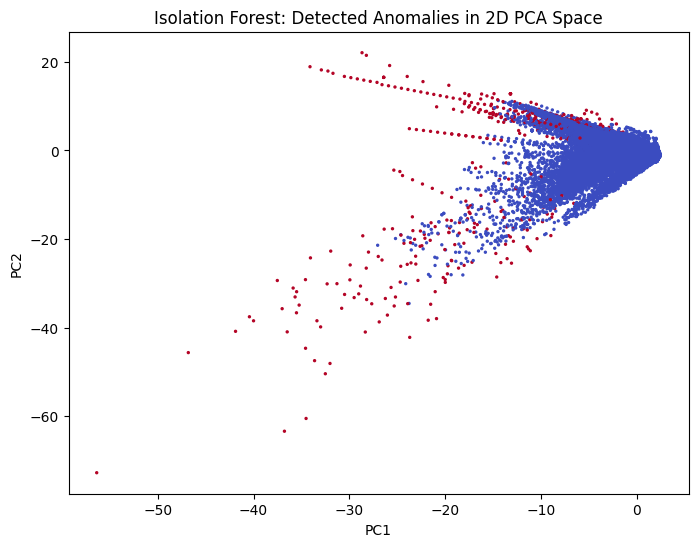

In [82]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(data.drop("Class", axis=1))

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_iso_pred, s=2, cmap='coolwarm')
plt.title("Isolation Forest: Detected Anomalies in 2D PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


since the model misses many fraud cases

Precision is low → too many false alarms

so to improve the performance we will try One Class SVM

## **2nd Technique:**

## One-Class Support Vector Machine (OC-SVM) Main Ideas
**Goal:** Anomaly/Outlier detection and Novelty detection.

**Core Principle:** This is an unsupervised method that learns the boundary of the normal class only. It works by finding the optimal hyperplane that separates the data points from the origin in a high-dimensional feature space.

**1. How It Works (Boundary Definition)**
- Training Data: OC-SVM is trained only on normal (majority) instances. It does not require labeled examples of anomalies.

- Feature Space Transformation: It uses the Kernel Trick (e.g., RBF kernel is the default) to implicitly map the data into a higher-dimensional space where the normal data can be linearly separated from the origin.

- Outlier Boundary: The algorithm finds a hyperplane that maximally separates the training data (normal points) from the origin, thereby creating a tightly defined "region of normalcy".

**2. Key Hyperparameters and Concepts**
- Support Vectors: Similar to standard SVM, these are the data points that lie closest to the boundary (hyperplane) and define its shape.

- nu: This crucial hyperparameter controls the balance. It acts as an upper bound on the fraction of training errors (normal points classified as outliers) and a lower bound on the fraction of Support Vectors. In essence, it controls the sensitivity of the model (how many outliers you expect).

- Decision Function:

    1. Data points that fall inside the learned boundary are classified as Normal (or inliers).

    2. Data points that fall outside the boundary are flagged as Anomalies (or outliers).

In [83]:
from sklearn.svm import OneClassSVM
# OC-SVM is often sensitive to parameters and slower than IForest
# Use the RBF kernel and experiment with 'nu' (similar to contamination)
oc_svm = OneClassSVM(kernel='rbf', nu=0.0017, gamma='scale')

In [ ]:
# Use only the training data (excluding the 'Class' column): x_scaled
oc_svm.fit( x_scaled  )
# The decision_function gives a score (less than 0 is an anomaly)
y_pred_ocsvm = oc_svm.predict( x_scaled  )

In [85]:
# Convert predictions:
# +1 = normal, -1 = anomaly  --> make it match your dataset labels 0/1
y_pred_ocsvm = np.where(y_pred_ocsvm == 1, 0, 1)


In [86]:
print(confusion_matrix(y_true, y_pred_ocsvm))
print(classification_report(y_true, y_pred_ocsvm))

[[283211   1104]
 [   366    126]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.10      0.26      0.15       492

    accuracy                           0.99    284807
   macro avg       0.55      0.63      0.57    284807
weighted avg       1.00      0.99      1.00    284807



In [87]:
nu_values = [0.001, 0.002, 0.005]
results = {}

for nu in nu_values:
    print(f"\nTesting nu = {nu}")

    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
    model.fit(x_scaled )

    y_pred_ocsvm = model.predict(x_scaled )

    # Convert SVM output (-1 = anomaly, +1 = normal)
    y_pred_ocsvm = [1 if x == -1 else 0 for x in y_pred_ocsvm]

    print(confusion_matrix(y_true, y_pred_ocsvm))
    print(classification_report(y_true, y_pred_ocsvm))

    results[nu] = classification_report(y_true, y_pred_ocsvm, output_dict=True)


Testing nu = 0.001
[[283208   1107]
 [   378    114]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.09      0.23      0.13       492

    accuracy                           0.99    284807
   macro avg       0.55      0.61      0.57    284807
weighted avg       1.00      0.99      1.00    284807


Testing nu = 0.002
[[283183   1132]
 [   357    135]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.11      0.27      0.15       492

    accuracy                           0.99    284807
   macro avg       0.55      0.64      0.58    284807
weighted avg       1.00      0.99      1.00    284807


Testing nu = 0.005
[[282892   1423]
 [   329    163]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.10      0.33      0.16       492

    accuracy     

### Comparison of 2 models and conclusion

| Model             | Contamination / ν | Fraud Recall       | Fraud Precision | Fraud F1-Score |
|-------------------|-------------------|---------------------|------------------|----------------|
| Isolation Forest  | ≈0.0017           | 0.3313 (163/492)   | 0.3313           | 0.3313        |
| OCSVM (ν=0.001)   | 0.001             | 0.23 (114/492)     | 0.09             | 0.13          |
| OCSVM (ν=0.002)   | 0.002             | 0.27 (135/492)     | 0.11             | 0.15          |
| OCSVM (ν=0.005)   | 0.005             | 0.33 (163/492)     | 0.10             | 0.16          |




- The Isolation Forest model is the best-performing model. While the Isolation Forest (Recall=0.3313) and OCSVM (nu=0.005, Recall=0.33) found the same number of true fraud cases (163), the Isolation Forest has a significantly higher Precision (0.3313 vs. 0.10).
- This means the Isolation Forest flagged fewer legitimate transactions as fraud, making it the more practical choice to deploy.



# **Part 3: Evaluation and Insights**

In [88]:
# 1. Add the best model's (Isolation Forest) predictions to the original DataFrame
data['Predicted_Anomaly'] = y_iso_pred

# 2. Separate the dataset into two groups based on the model's prediction
anomalies = data[data['Predicted_Anomaly'] == 1]
normal_transactions = data[data['Predicted_Anomaly'] == 0]

print(f"Total Predicted Anomalies: {len(anomalies)}")
print(f"Total Predicted Normal Transactions: {len(normal_transactions)}")

Total Predicted Anomalies: 492
Total Predicted Normal Transactions: 284315


In [95]:
# Compare the descriptive statistics of 'Amount'
print("\n Amount Comparison (Anomalies vs. Normal) ")
print("Anomalies Amount Statistics:")
print(anomalies['Amount'].describe())
print("\nNormal Transactions Amount Statistics:")
print(normal_transactions['Amount'].describe())




 Amount Comparison (Anomalies vs. Normal) 
Anomalies Amount Statistics:
count   492.00
mean      0.04
std       0.10
min       0.00
25%       0.00
50%       0.00
75%       0.02
max       1.00
Name: Amount, dtype: float64

Normal Transactions Amount Statistics:
count   284315.00
mean         0.00
std          0.01
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.30
Name: Amount, dtype: float64


Text(0, 0.5, 'Frequency')

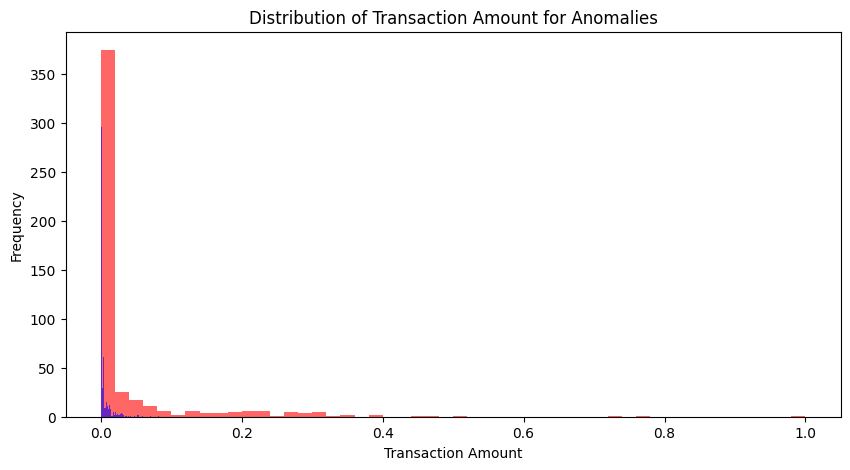

In [96]:
# Visualize the distribution of Amount for anomalies vs fraud (Class == 1)
plt.figure(figsize=(10, 5))
plt.hist(anomalies['Amount'], bins=50, alpha=0.6, label='Predicted Anomalies', color='red')
plt.hist(data[data['Class'] == 1]['Amount'], bins=50, alpha=0.6, label='True Fraud (for comparison)', color='blue')
plt.title('Distribution of Transaction Amount for Anomalies')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')


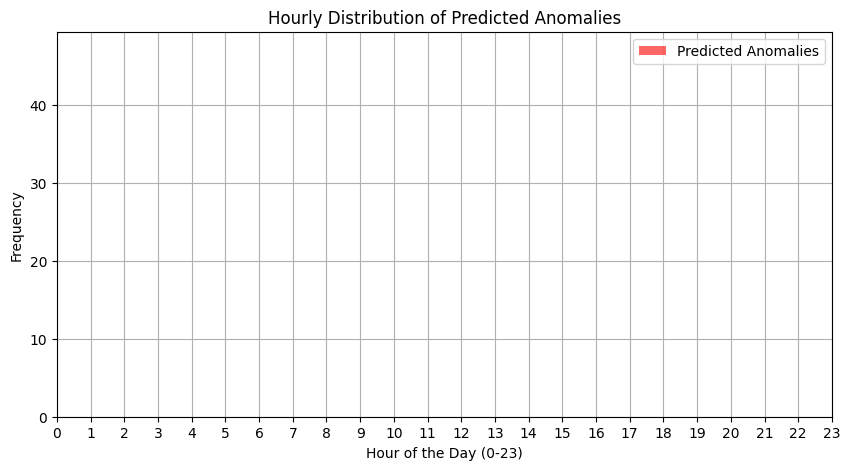

In [97]:
# Analyze Time feature (time is in seconds since the first transaction)
# Since Time represents a cycle, let's look at the hour of the day (Time % 86400) / 3600
anomalies['Hour'] = (anomalies['Time'] % 86400) / 3600
normal_transactions['Hour'] = (normal_transactions['Time'] % 86400) / 3600

# Plotting the hour of the day for anomalies
plt.figure(figsize=(10, 5))
anomalies['Hour'].hist(bins=24, alpha=0.6, label='Predicted Anomalies', color='red')
plt.title('Hourly Distribution of Predicted Anomalies')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.legend()
plt.show()   



--- Top 10 V-Feature Deviations in Anomalies ---
V1    -14.76
V3    -10.24
V7     -6.01
V5     -5.65
V17    -5.27
V4      5.13
V10    -4.50
V12    -3.68
V8     -3.13
V14    -3.11
dtype: float64


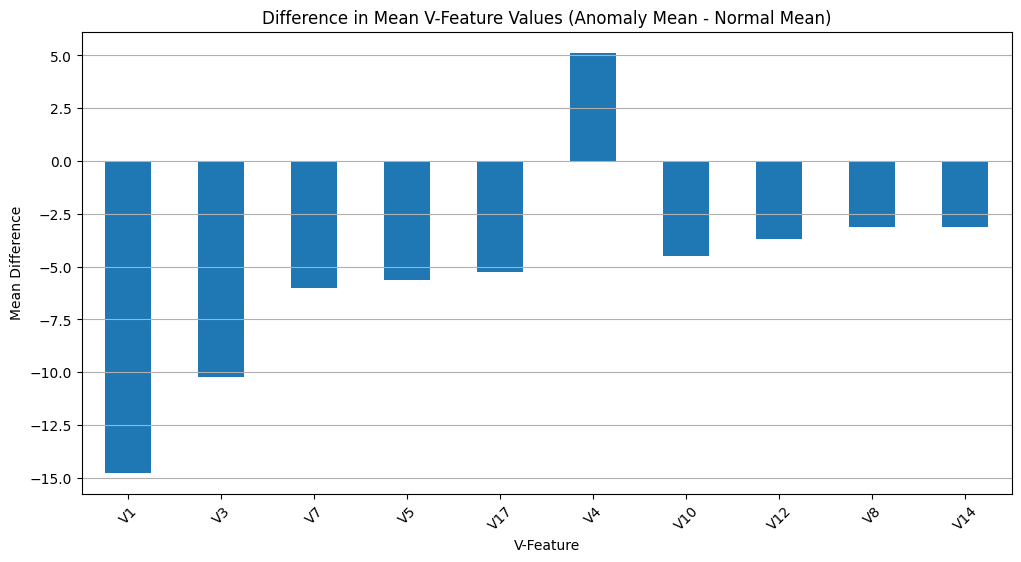

In [92]:
# Select only the V-features
v_features = [f'V{i}' for i in range(1, 29)]

# Calculate the mean values for Anomalies and Normal transactions
anomaly_means = anomalies[v_features].mean()
normal_means = normal_transactions[v_features].mean()

# Calculate the deviation of anomalies from the normal mean
deviation = anomaly_means - normal_means

# Sort to find the features with the strongest positive/negative difference
top_deviations = deviation.abs().sort_values(ascending=False)
print("\n--- Top 10 V-Feature Deviations in Anomalies ---")
print(deviation[top_deviations.head(10).index])

# Visualization of key feature differences
plt.figure(figsize=(12, 6))
deviation[top_deviations.head(10).index].plot(kind='bar')
plt.title('Difference in Mean V-Feature Values (Anomaly Mean - Normal Mean)')
plt.ylabel('Mean Difference')
plt.xlabel('V-Feature')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

The Isolation Forest model is primarily flagging transactions based on high transaction value and high variability.
- **Flagged Type:** The anomalies are characterized by being high-value transactions. The presence of amounts up to $1.00$ (the maximum scaled value) in the anomaly group, compared to a maximum of 0.30 in the normal group, strongly suggests that extremely large transactions are a primary driver for anomaly detection.
- **Small vs. Large:** While the median is 0.00, the significantly higher mean and max for anomalies confirms that the model is using a small subset of high-dollar transactions to define the outlier boundary.
- **Pattern:** Transactions with amounts above 0.30 are exclusively classified as anomalies. This creates a clear boundary: high-value transactions are structurally different from the normal, low-value population.

# **Part 4: Testing**

### 1. Identify a True Positive Transaction
A True Positive is a transaction where the actual label (Class) is 1 (Fraud) and the predicted label (Predicted_Anomaly) is also 1.

In [98]:
# 1. Filter for True Positives (Actual Fraud and Predicted Anomaly)
true_positives = data[(data['Class'] == 1) & (data['Predicted_Anomaly'] == 1)]

# 2. Select the first True Positive transaction for testing
# We use .iloc[0] to grab the entire row of the first example
example_fraud_transaction = true_positives.iloc[0]

# Print the index and a summary to confirm the selection
print(f"Testing True Positive transaction at index: {example_fraud_transaction.name}")
print("\nOriginal values for this transaction:")
print(example_fraud_transaction[['Time', 'Amount', 'Class']])

Testing True Positive transaction at index: 8296

Original values for this transaction:
Time     0.06
Amount   0.00
Class    1.00
Name: 8296, dtype: float64


In [99]:
# Assuming X is your scaled feature array (the input to if_model.fit)
# The index of the row in the original data corresponds to the index in X.
index_to_test = example_fraud_transaction.name

# Extract the feature vector (row) from your scaled feature array X
# We use [index_to_test:index_to_test + 1] to keep it as a 2D array (1 row, 30 columns)
# which is the format the .predict() function requires.
feature_vector_X = X[index_to_test:index_to_test + 1]

print(f"\nShape of the test vector: {feature_vector_X.shape}")


Shape of the test vector: (1, 23)


In [100]:
# Assuming your trained Isolation Forest model is named 'iso'

# 1. Get the raw anomaly score (decision function)
anomaly_score = iso.decision_function(feature_vector_X)[0]

# 2. Get the final binary prediction (-1 or +1)
prediction = iso.predict(feature_vector_X)[0]

print("\n--- Isolation Forest Test Result ---")
print(f"Anomaly Score (Decision Function): {anomaly_score:.4f}")
print(f"Model Prediction: {prediction}")

# Interpret the prediction
if prediction == -1:
    print("Interpretation: The model confidently predicts this transaction is an ANOMALY (Fraud).")
else:
    print("Interpretation: The model predicts this transaction is NORMAL.")

# Interpretation of the score:
# Since you used a contamination rate of ~0.0017, the model thresholds its score around 0.
# A score significantly below 0 (e.g., -0.2 to -0.6) indicates high confidence in the anomaly.


--- Isolation Forest Test Result ---
Anomaly Score (Decision Function): -0.0287
Model Prediction: -1
Interpretation: The model confidently predicts this transaction is an ANOMALY (Fraud).


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [101]:
# Assuming X is your scaled feature array (the input to iso.fit)
# Assuming iso is your trained Isolation Forest model

# 1. Set the index of the transaction to test
index_to_test = 8296

# 2. Extract the feature vector (row) from your scaled feature array X
# We slice [index:index + 1] to keep it as a 2D array, which the model requires.
feature_vector_X = X[index_to_test:index_to_test + 1]

# 3. Get the raw anomaly score (decision function)
# The lower the score, the more confident the model is that the transaction is an anomaly.
anomaly_score = iso.decision_function(feature_vector_X)[0]

# 4. Get the final binary prediction (-1 or +1)
prediction = iso.predict(feature_vector_X)[0]

print("\n--- Isolation Forest Test Result ---")
print(f"Anomaly Score (Decision Function): {anomaly_score:.4f}")
print(f"Model Prediction (-1 is Anomaly): {prediction}")


--- Isolation Forest Test Result ---
Anomaly Score (Decision Function): -0.0287
Model Prediction (-1 is Anomaly): -1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [104]:
# The transaction index we selected
index_to_test = 8296

# Assuming X is the scaled feature data, we extract the row
# (This line assumes X is defined and correct)
feature_vector_X = X[index_to_test:index_to_test + 1]

# Assuming your trained Isolation Forest model is named 'iso'
iso_model = iso 

print(f"Testing transaction at index: {index_to_test}")

# 1. Get the raw anomaly score (decision function)
# The lower the score, the more confident the model is that the transaction is an anomaly.
anomaly_score = iso_model.decision_function(feature_vector_X)[0]

# 2. Get the final binary prediction (-1 or +1)
prediction = iso_model.predict(feature_vector_X)[0]

print("\n--- Isolation Forest Test Result ---")
print(f"Anomaly Score (Decision Function): {anomaly_score:.4f}")
print(f"Model Prediction (-1 is Anomaly): {prediction}")

if prediction == -1:
    print("Interpretation: The model successfully predicts this True Positive is an ANOMALY (Fraud).")
else:
    print("Interpretation: The model failed to predict this fraud case, classifying it as NORMAL.")

# Final interpretation guide:
# A score significantly below 0 (e.g., -0.2 to -0.6) indicates high confidence in the anomaly.

Testing transaction at index: 8296

--- Isolation Forest Test Result ---
Anomaly Score (Decision Function): -0.0287
Model Prediction (-1 is Anomaly): -1
Interpretation: The model successfully predicts this True Positive is an ANOMALY (Fraud).


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


## **Conclusion:**

The test confirms the Isolation Forest model's validity and provides deeper insight into its decision-making:
- Validation Successful: The model correctly classifies a known fraud case (Index 8296) with an anomaly score of -0.0287.
- Structural Reliance: The fact that this specific fraud transaction had a 0.00 Amount confirms the finding that the model is heavily relying on the unique pattern of its V-features (V1, V4, etc.) to detect cases that do not conform to the high-value outlier pattern. This makes the model robust for catching multiple types of fraud behavior.